<a href="https://colab.research.google.com/github/Stock-XAI/LLM_server/blob/main/API_server.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade pip
!pip install fastapi uvicorn nest-asyncio pyngrok
!pip install transformers accelerate torch pandas yfinance bitsandbytes peft shap matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 54.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 

In [3]:
import nest_asyncio
from fastapi import FastAPI, Query
from pyngrok import ngrok
from threading import Thread
import uvicorn

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np
import re
import shap
import matplotlib.pyplot as plt

from huggingface_hub import login
from google.colab import userdata
login(token=userdata.get('HF_TOKEN'))

### 모델 로드 및 준비

In [5]:
bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

base_model = AutoModelForCausalLM.from_pretrained(
    "capston-team-5/finma-7b-4bit-quantized",
    quantization_config=bnb_cfg,
    device_map="auto"
)
model = PeftModel.from_pretrained(base_model, "capston-team-5/finma-7b-lora-regression-v1")
tokenizer = AutoTokenizer.from_pretrained("capston-team-5/finma-7b-lora-regression-v1")
model.eval()

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/quantizers/auto.py:222: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/3.87G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['pad_token_id']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['pad_token_id']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/871 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/320M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=31999)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
         

### 프롬프트 생성 및 추론 함수

In [132]:
def generate_prompt(ticker, interval, context, date_str):
    return (
        f"Using the context below, estimate the rate of change in the closing price of {ticker} on {date_str}.\n"
        "Return the expected value of change as a decimal.\n\n"
        "Context: date, open, high, low, close, volume, change.\n"
        f"{context}\n\nAnswer:"
    )

def generate_response(prompt, max_new_tokens=128):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

def get_prompt(ticker: str, horizon_days: int):
    assert horizon_days in [1, 7, 30], "Only 1, 7, or 30 day horizon supported"
    today = datetime.today()
    predict_date = today + timedelta(days=horizon_days)
    interval, fetch_days = ("1d", 15) if horizon_days == 1 else ("1wk", 70) if horizon_days == 7 else ("1mo", 300)
    start = (today - timedelta(days=fetch_days)).strftime("%Y-%m-%d")
    end = (today + timedelta(days=1)).strftime("%Y-%m-%d")

    data = yf.download(ticker, start=start, end=end, interval=interval)[["Open", "High", "Low", "Close", "Volume"]]
    data = data.reset_index()
    data["Date"] = data["Date"].dt.strftime("%Y-%m-%d")
    data["Change"] = data["Close"].pct_change().fillna(0)

    last_10 = data.tail(10)

    def extract(val):
        return val.iloc[0] if isinstance(val, pd.Series) else val
    context = "\n".join([
        f"{extract(row['Date'])}, {float(extract(row['Open']))}, {float(extract(row['High']))}, {float(extract(row['Low']))}, "
        f"{float(extract(row['Close']))}, {int(extract(row['Volume']))}, {float(extract(row['Change'])):.6f}"
        for _, row in last_10.iterrows()
    ])

    prompt = generate_prompt(ticker, interval, context, predict_date.strftime("%Y-%m-%d"))
    response = generate_response(prompt)

    return prompt

def run_prediction(ticker: str, horizon_days: int):
    prompt = get_prompt(ticker, horizon_days)
    response = generate_response(prompt)
    return response.split("Answer:")[-1].strip(), prompt, response

In [133]:
_, prompt, response = run_prediction("AAPL", 1)
print(response)

[*********************100%***********************]  1 of 1 completed


Using the context below, estimate the rate of change in the closing price of AAPL on 2025-06-06.
Return the expected value of change as a decimal.

Context: date, open, high, low, close, volume, change.
2025-05-21, 205.1699981689453, 207.0399932861328, 200.7100067138672, 202.08999633789062, 59211800, 0.000000
2025-05-22, 200.7100067138672, 202.75, 199.6999969482422, 201.36000061035156, 46742400, -0.003612
2025-05-23, 193.6699981689453, 197.6999969482422, 193.4600067138672, 195.27000427246094, 78432900, -0.030244
2025-05-27, 198.3000030517578, 200.74000549316406, 197.42999267578125, 200.2100067138672, 56288500, 0.025298
2025-05-28, 200.58999633789062, 202.72999572753906, 199.89999389648438, 200.4199981689453, 45339700, 0.001049
2025-05-29, 203.5800018310547, 203.80999755859375, 198.50999450683594, 199.9499969482422, 51396800, -0.002345
2025-05-30, 199.3699951171875, 201.9600067138672, 196.77999877929688, 200.85000610351562, 70819900, 0.004501
2025-06-02, 200.27999877929688, 202.13000488

### SHAP/XAI 설명 함수

In [127]:
def explain_prediction(prompt, tokenizer, model):
    input_ids = tokenizer(prompt, return_tensors="pt")["input_ids"].to(model.device)

    inputs_embeds = model.base_model.model.model.embed_tokens(input_ids)
    inputs_embeds.requires_grad_()

    outputs = model(inputs_embeds=inputs_embeds, labels=input_ids)
    loss = outputs.loss
    loss.backward()

    grads = inputs_embeds.grad.abs().sum(dim=-1).squeeze().detach().cpu().numpy()
    grads /= grads.sum()

    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    tokens = [t.replace('▁', '▁') for t in tokens]

    return grads, tokens

grads, tokens = explain_prediction(prompt, tokenizer, model)

In [130]:
def group_tokens_to_words(tokens, scores, group_size=7):
    words, word_indices = [], []
    current_word, current_indices = "", []

    # 1. 단어 단위로 묶기
    for i, tok in enumerate(tokens):
        # 줄바꿈, 특수 토큰 무시
        if tok in ["<0x0A>", "\\n", "\n"] or re.fullmatch(r"<0x0A>", tok):
            if current_word:
                words.append(current_word)
                word_indices.append(current_indices)
                current_word, current_indices = "", []
            continue
        elif tok.startswith('▁'):  # 새로운 단어 시작
            if current_word:
                words.append(current_word)
                word_indices.append(current_indices)
            current_word = tok[1:]
            current_indices = [i]
        else:
            current_word += tok
            current_indices.append(i)
    if current_word:
        words.append(current_word)
        word_indices.append(current_indices)

    # 2. 깨진 문자 정리
    words = [re.sub(r'<0x[A-Fa-f0-9]+>', '', w) for w in words]
    words = [re.sub(r'\\n', '', w) for w in words]
    words = [w.strip() for w in words if w.strip() != '']

    # 3. 단어별 importance 집계
    word_scores = []
    for indices in word_indices:
        score = sum(grads[i] for i in indices)
        word_scores.append(score)

    words = words[35:len(words)-1]
    word_scores = word_scores[35:len(word_scores)-1]

    def Make_Token_List(words, words_scores):
        temp = words.copy()
        temp_score = word_scores.copy()
        for i in range(len(temp)):
            temp[i] = temp[i][:len(temp[i]) - 1]
        token_list = []
        for i in range(0, len(temp), 7):
            token_list.append(temp[i:i + 7])
        token_score_list = []
        for i in range(0, len(temp), 7):
            token_score_list.append(temp_score[i:i + 7])

        return token_list, token_score_list

    return Make_Token_List(words, word_scores)

token_list, token_score_list = group_tokens_to_words(tokens, grads)

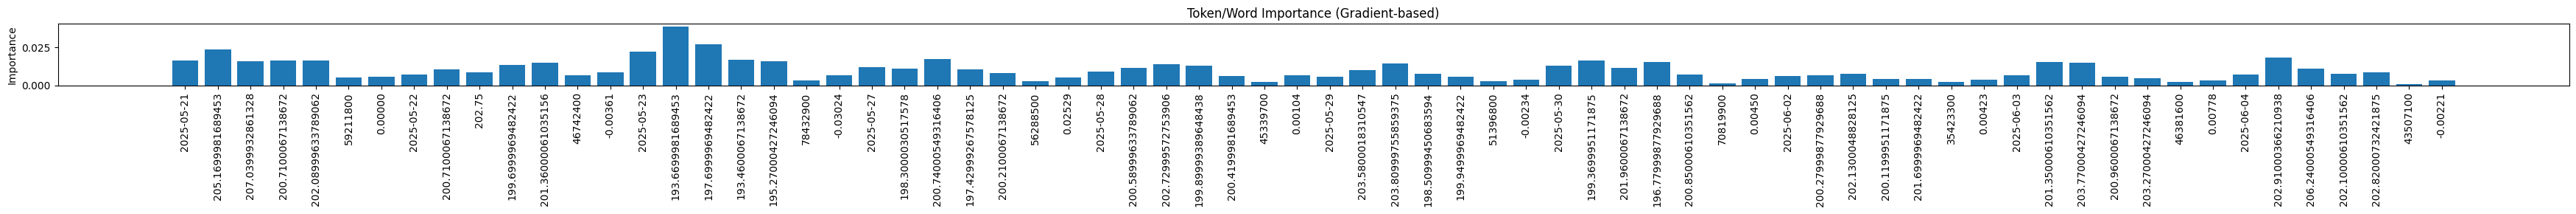

In [131]:
import matplotlib.pyplot as plt

flat_words = sum(token_list, [])
flat_scores = sum(token_score_list, [])

plt.figure(figsize=(max(12, len(flat_words)//2), 3))
plt.bar(range(len(flat_words)), flat_scores)
plt.xticks(range(len(flat_words)), flat_words, rotation=90)
plt.title("Token/Word Importance (Gradient-based)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


### FastAPI 서버/엔드포인트 구현

In [134]:
nest_asyncio.apply()
app = FastAPI()

@app.get("/predict")
def predict(ticker: str = Query(...), horizon_days: int = Query(...)):
    result, prompt, _ = run_prediction(ticker, horizon_days)
    return {
        "ticker": ticker,
        "horizon_days": horizon_days,
        "prediction_date": (datetime.today() + timedelta(days=horizon_days)).strftime("%Y-%m-%d"),
        "prediction_result": result,
        "prompt": prompt
    }

@app.get("/explain")
def explain(ticker: str = Query(...), horizon_days: int = Query(...)):
    prompt = get_prompt(ticker, horizon_days)
    grads, tokens = explain_prediction(prompt, tokenizer, model)
    token_list, token_score_list = group_tokens_to_words(tokens, grads)

    return {
        "token_list": token_list,
        "token_score_list": token_score_list
    }


### 서버 실행 & ngrok 공개

In [136]:
ngrok_token = userdata.get('NGROK_TOKEN')
!ngrok config add-authtoken $ngrok_token

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [137]:
port = 7861
Thread(target=lambda: uvicorn.run(app, host="0.0.0.0", port=port)).start()
public_url = ngrok.connect(port)
print(f"🚀 API Ready: {public_url}/predict?ticker=005930.KS&horizon_days=1")


INFO:     Started server process [857]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
ERROR:    [Errno 98] error while attempting to bind on address ('0.0.0.0', 7861): address already in use
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.


🚀 API Ready: NgrokTunnel: "https://66af-34-142-217-55.ngrok-free.app" -> "http://localhost:7861"/predict?ticker=005930.KS&horizon_days=1


In [138]:
import time
_time = 0
while(True):
    time.sleep(300)
    _time += 300
    print("Running Time:", _time, "sec")
    continue

INFO:     203.252.33.4:0 - "GET / HTTP/1.1" 404 Not Found
INFO:     203.252.33.4:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-4' coro=<Server.serve() done, defined at /usr/local/lib/python3.11/dist-packages/uvicorn/server.py:68> exception=SystemExit(1)>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 163, in startup
    server = await loop.create_server(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/asyncio/base_events.py", line 1536, in create_server
    raise OSError(err.errno, msg) from None
OSError: [Errno 98] error while attempting to bind on address ('0.0.0.0', 7861): address already in use

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-137-98be93ffd7f4>", line 2, in <lam

INFO:     203.252.33.4:0 - "GET /predict?ticker=AAPL&horizon_days=1 HTTP/1.1" 200 OK


[*********************100%***********************]  1 of 1 completed


INFO:     203.252.33.4:0 - "GET /predict?ticker=AAPL&horizon_days=7 HTTP/1.1" 200 OK


[*********************100%***********************]  1 of 1 completed


INFO:     203.252.33.4:0 - "GET /predict?ticker=AAPL&horizon_days=30 HTTP/1.1" 200 OK


[*********************100%***********************]  1 of 1 completed


INFO:     203.252.33.4:0 - "GET /predict?ticker=AAPL&horizon_days=7 HTTP/1.1" 200 OK


KeyboardInterrupt: 